# 利用信号处理和神经网络预测非平稳时间序列

"时序数据"和"时序信号"通常可以理解为相似的概念，但在一些上下文中可能会有细微的区别。这两个术语都描述了随时间变化的信息。

**时序数据**： 这个术语更通用，可用于描述按时间排序的任何数据。时序数据可以包括各种类型的信息，例如温度、股票价格、销售额、气象数据等。时序数据是一个广泛的范畴，可以表示任何以时间为基础的观测、记录或测量。

**时序信号**： 这个术语通常与信号处理领域相关，描述的是按时间顺序变化的信号。时序信号可能涉及到物理或工程领域中的传感器数据、音频信号、振动信号等。时序信号的处理通常涉及对信号的分析、滤波、频谱分解等操作。

在某些上下文中，这两个术语可能被互换使用，因为它们描述的实际上是相同的概念，即随时间变化的数据或信号。然而，具体的使用可能会根据领域和上下文而有所不同。**在信号处理、时间序列分析或机器学习等领域，这两个术语通常可以互换使用。**

In [24]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils import weight_norm

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 加载数据集

In [2]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


## 变分模态分解

In [5]:
from vmdpy import VMD # 加载VMD模块

In [3]:
load = ts_data['load'].values.astype('float32')
load.shape

(26304,)

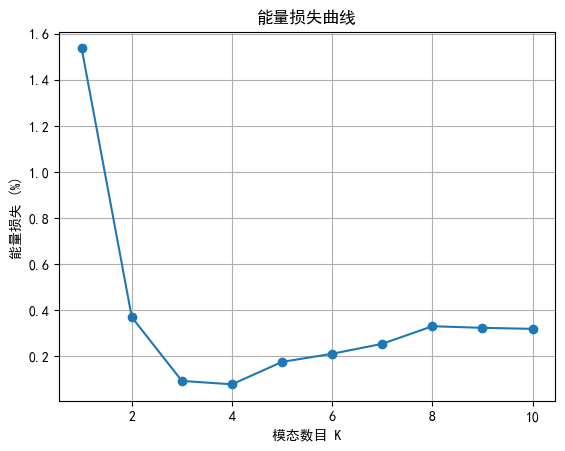

In [6]:
# 设置VMD参数
signal = load
alpha = 500.0  # 数据保真性约束的平衡参数
tau = 0.  # 对偶上升法的时间步长
K_values = range(1, 11)  # 尝试不同的K值
DC = True  # 第一个模态放置在直流分量
init = 0  # 所有频率从0开始初始化
tol = 1e-6  # 收敛标准的容差

# 记录能量损失
energy_losses = []

# 进行VMD分解并计算能量损失
for K in K_values:
    u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)
    
    # 计算每个模态的能量占总能量的比例
    energy = np.sum([np.sum(mode**2) for mode in u])
    total_energy = np.sum(signal**2)
    energy_loss = (1 - energy / total_energy) * 100
    energy_losses.append(energy_loss)

# 绘制能量损失曲线
plt.plot(K_values, energy_losses, marker='o')
plt.xlabel('模态数目 K')
plt.ylabel('能量损失 (%)')
plt.title('能量损失曲线')
plt.grid(True)
plt.show()

In [7]:
K = np.where(np.array(energy_losses) == np.array(energy_losses).min())[0][0] # 选择能量损失最小的最为K值
# 构造参数字典
vmd_args = {
    "f": load, # 要分解的时间域信号（1D数组）
    "alpha": 500., # 数据保真性约束的平衡参数
    "tau": 0., # 对偶上升法的时间步长（选择0表示噪声松弛）
    "K": K, # 要恢复的模态数
    "DC": True, # 如果为真，第一个模态放置在并保持在直流分量（0频率）
    "init": 0, # 初始化模态中心频率的方式。0：所有频率从0开始。1：所有频率均匀分布开始。2：所有频率以随机方式初始化。
    "tol": 1e-6, #  收敛标准的容差
}

#函数传参
u, u_hat, omega = VMD(**vmd_args)  # 设置模态数目
# u 是分解得到的模态
# u_hat 是各模态的频谱
# omega 是估计的模态中心频率

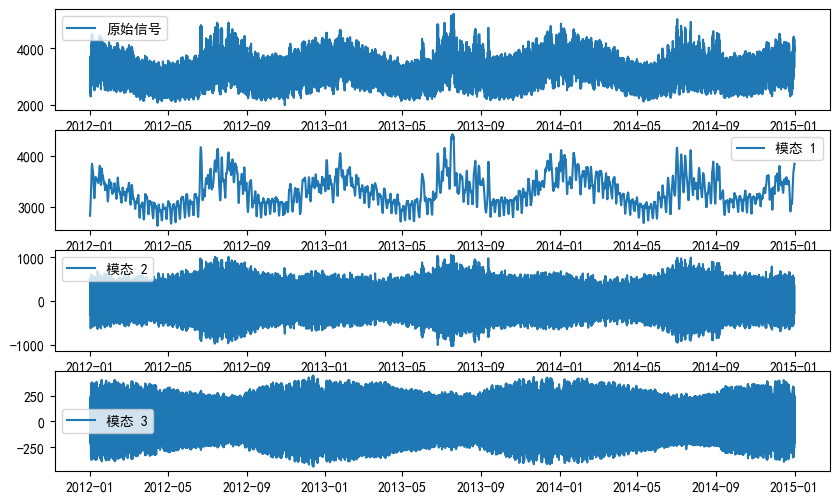

In [8]:
# 绘制原始信号及其分量
K = 3 # 要恢复的模态数
plt.figure(figsize=(10, 6))

plt.subplot(K + 1, 1, 1)
plt.plot(ts_data.index, load, label='原始信号')
plt.legend()

for i, mode in enumerate(u):
    plt.subplot(K + 1, 1, i + 2)
    plt.plot(ts_data.index, mode, label=f'模态 {i + 1}')
    plt.legend()

plt.show()

## 重构数据集

In [17]:
vmd_data = pd.DataFrame(u.T, index=ts_data.index, columns=['mode1', 'mode2', 'mode3'])

In [18]:
data = pd.concat([ts_data, vmd_data], axis=1)
data.head()

,load,temp,mode1,mode2,mode3
2012-01-01 00:00:00,"2,698.00",32.00,"2,823.66",-304.18,124.85
2012-01-01 01:00:00,"2,558.00",32.67,"2,819.97",-308.66,66.06
2012-01-01 02:00:00,"2,444.00",30.00,"2,817.42",-308.49,-19.29
2012-01-01 03:00:00,"2,402.00",31.00,"2,818.17",-297.05,-93.40
2012-01-01 04:00:00,"2,403.00",32.00,"2,821.02",-272.74,-129.79


## 数据准备

In [1]:
# 包含时间维度的数据集划分
def divide_dataset(df, test_date, valid_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [21]:
# 构造参数字典
params1 = {
    "df": data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["mode1", "mode2", "mode3"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 3) y_train shape: (23376, 1)
x_valid shape: (1464, 3) y_valid shape: (1464, 1)
x_test shape: (1464, 3) y_test shape: (1464, 1)


In [22]:
#利用前lookback个数据，预测下delay个数据
def rnn_create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X) # X为三维
    y = torch.as_tensor(y) 
    y = y.squeeze(dim=2) #去掉维度为1的第三维度，将其变为二维
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [25]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 3]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 6, 3]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 6, 3]),y_size: torch.Size([1458, 1]),loader_len: 46


## 模型训练

In [26]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True):
    #LSTM
    class LSTM(nn.Module):
        def __init__(self, input_dim, out_dim):
            super().__init__()
            self.lstm = nn.LSTM(input_size=input_dim, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(in_features=5, out_features=out_dim)
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #训练模型
    model = LSTM(input_dim=input_dim, out_dim=out_dim).to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            outputs = outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)[:,-1, -1:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

In [28]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

  5%|████▏                                                                              | 1/20 [00:01<00:27,  1.43s/it]

Epoch [1/20], Training Loss: 0.0120, Validation Loss: 0.0040


 10%|████████▎                                                                          | 2/20 [00:02<00:25,  1.41s/it]

Epoch [2/20], Training Loss: 0.0006, Validation Loss: 0.0029


 15%|████████████▍                                                                      | 3/20 [00:04<00:23,  1.40s/it]

Epoch [3/20], Training Loss: 0.0004, Validation Loss: 0.0025


 20%|████████████████▌                                                                  | 4/20 [00:05<00:22,  1.41s/it]

Epoch [4/20], Training Loss: 0.0003, Validation Loss: 0.0024


 25%|████████████████████▊                                                              | 5/20 [00:07<00:21,  1.45s/it]

Epoch [5/20], Training Loss: 0.0002, Validation Loss: 0.0022


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:20,  1.48s/it]

Epoch [6/20], Training Loss: 0.0002, Validation Loss: 0.0023


 35%|█████████████████████████████                                                      | 7/20 [00:10<00:19,  1.51s/it]

Epoch [7/20], Training Loss: 0.0002, Validation Loss: 0.0020


 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:18,  1.54s/it]

Epoch [8/20], Training Loss: 0.0002, Validation Loss: 0.0020


 45%|█████████████████████████████████████▎                                             | 9/20 [00:13<00:17,  1.55s/it]

Epoch [9/20], Training Loss: 0.0001, Validation Loss: 0.0017


 50%|█████████████████████████████████████████                                         | 10/20 [00:15<00:15,  1.59s/it]

Epoch [10/20], Training Loss: 0.0001, Validation Loss: 0.0018


 55%|█████████████████████████████████████████████                                     | 11/20 [00:16<00:14,  1.61s/it]

Epoch [11/20], Training Loss: 0.0001, Validation Loss: 0.0018


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:18<00:12,  1.62s/it]

Epoch [12/20], Training Loss: 0.0001, Validation Loss: 0.0019


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:20<00:11,  1.63s/it]

Epoch [13/20], Training Loss: 0.0001, Validation Loss: 0.0018


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:21<00:09,  1.64s/it]

Epoch [14/20], Training Loss: 0.0001, Validation Loss: 0.0016


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:23<00:08,  1.65s/it]

Epoch [15/20], Training Loss: 0.0001, Validation Loss: 0.0018


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:25<00:06,  1.73s/it]

Epoch [16/20], Training Loss: 0.0001, Validation Loss: 0.0019


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:27<00:05,  1.76s/it]

Epoch [17/20], Training Loss: 0.0001, Validation Loss: 0.0017


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:28<00:03,  1.72s/it]

Epoch [18/20], Training Loss: 0.0001, Validation Loss: 0.0017


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:30<00:01,  1.69s/it]

Epoch [19/20], Training Loss: 0.0001, Validation Loss: 0.0018


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]

Epoch [20/20], Training Loss: 0.0001, Validation Loss: 0.0017


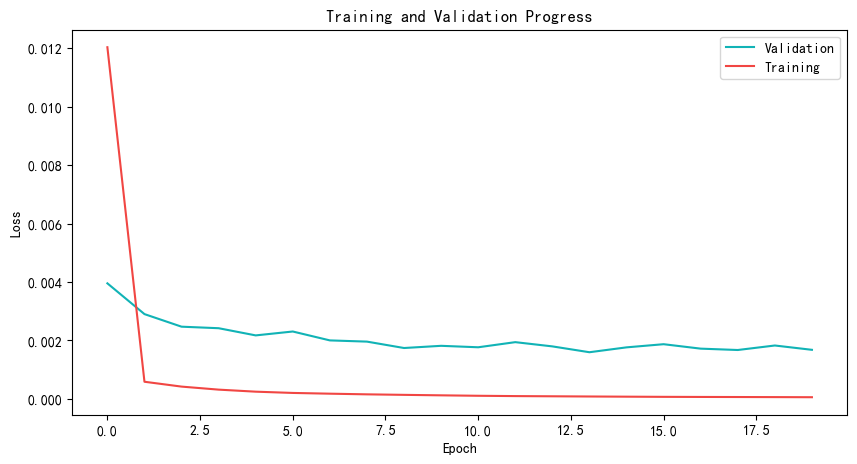

In [29]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 20,
    "input_dim": 3,
    "out_dim": 1,
    "verbose": True,
    "plots": True,
}
model = train(**params3)

## 模型预测

In [30]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出，并将其变为二维
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [31]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

## 结果分析

In [32]:
# 局部静态图
def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

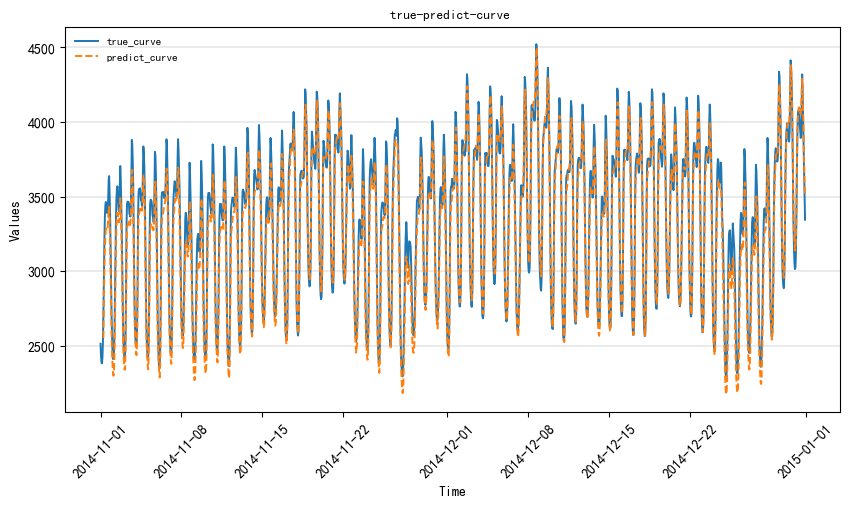

In [33]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)